In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

import math

from subprocess import check_output

print(check_output(["ls", "../data/mercari"]).decode("utf8"))

sample_submission.csv
sample_submission_stg2.csv
test.tsv
test_stg2.tsv
train.tsv



In [2]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i, pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0 / len(y))) ** 0.5

In [3]:
print("Loading data...")
train = pd.read_table("../data/mercari/train.tsv")
test = pd.read_table("../data/mercari/test.tsv")
print(train.shape)
print(test.shape)

Loading data...
(1482535, 8)
(693359, 7)


In [4]:
print("Handling missing values...")


def handle_missing(dataset):
    dataset.category_name.fillna(value="missing", inplace=True)
    dataset.brand_name.fillna(value="missing", inplace=True)
    dataset.item_description.fillna(value="missing", inplace=True)
    return (dataset)


train = handle_missing(train)
test = handle_missing(test)
print(train.shape)
print(test.shape)

Handling missing values...


/var/folders/3g/9z2y6vy916ncn7tzc7rkg8140000gn/T/ipykernel_86775/1821236504.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset.category_name.fillna(value="missing", inplace=True)
/var/folders/3g/9z2y6vy916ncn7tzc7rkg8140000gn/T/ipykernel_86775/1821236504.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

(1482535, 8)
(693359, 7)


In [5]:
train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [6]:
print("Handling categorical variables...")
le = LabelEncoder()

le.fit(np.hstack([train.category_name, test.category_name]))
train.category_name = le.transform(train.category_name)
test.category_name = le.transform(test.category_name)

le.fit(np.hstack([train.brand_name, test.brand_name]))
train.brand_name = le.transform(train.brand_name)
test.brand_name = le.transform(test.brand_name)
del le

train.head(3)

Handling categorical variables...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...


In [7]:
print("Text to seq process...")
from tensorflow.keras.preprocessing.text import Tokenizer

raw_text = np.hstack([train.item_description.str.lower(), train.name.str.lower()])

print("   Fitting tokenizer...")
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)
print("   Transforming text to seq...")

train["seq_item_description"] = tok_raw.texts_to_sequences(train.item_description.str.lower())
test["seq_item_description"] = tok_raw.texts_to_sequences(test.item_description.str.lower())
train["seq_name"] = tok_raw.texts_to_sequences(train.name.str.lower())
test["seq_name"] = tok_raw.texts_to_sequences(test.name.str.lower())
train.head(3)

Text to seq process...
   Fitting tokenizer...
   Transforming text to seq...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet,"[12, 68, 79]","[3852, 8823, 6896, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...","[10760, 25565, 16369, 2627]"
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[604, 60, 9, 4, 5347, 11, 192, 1, 4, 886, 1290...","[7634, 10563, 666]"


In [8]:
max_name_seq = np.max([np.max(train.seq_name.apply(lambda x: len(x))), np.max(test.seq_name.apply(lambda x: len(x)))])
max_seq_item_description = np.max([np.max(train.seq_item_description.apply(lambda x: len(x)))
                                      , np.max(test.seq_item_description.apply(lambda x: len(x)))])
print("max name seq " + str(max_name_seq))
print("max item desc seq " + str(max_seq_item_description))

max name seq 17
max item desc seq 269


<Axes: >

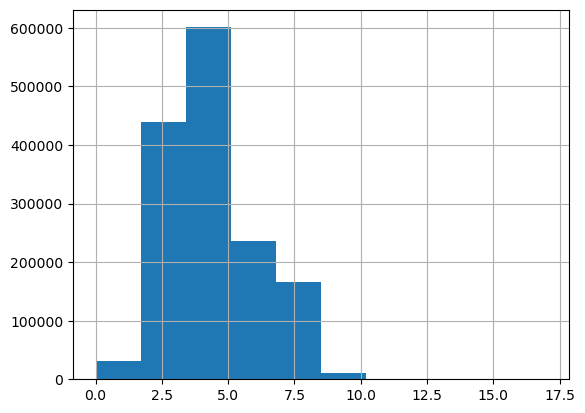

In [9]:
train.seq_name.apply(lambda x: len(x)).hist()

<Axes: >

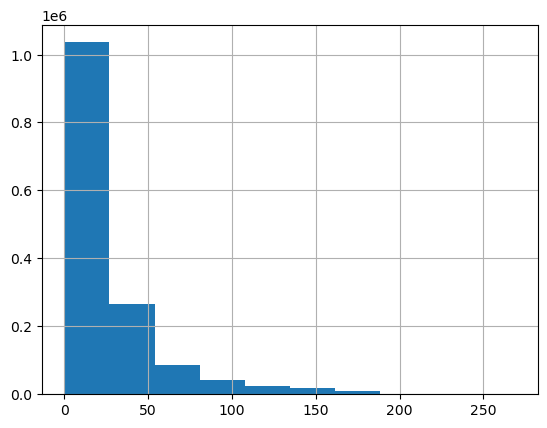

In [10]:
train.seq_item_description.apply(lambda x: len(x)).hist()

In [11]:
MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75
MAX_TEXT = np.max([np.max(train.seq_name.max())
                      , np.max(test.seq_name.max())
                      , np.max(train.seq_item_description.max())
                      , np.max(test.seq_item_description.max())]) + 2
MAX_CATEGORY = np.max([train.category_name.max(), test.category_name.max()]) + 1
MAX_BRAND = np.max([train.brand_name.max(), test.brand_name.max()]) + 1
MAX_CONDITION = np.max([train.item_condition_id.max(), test.item_condition_id.max()]) + 1

In [12]:
train["target"] = np.log(train.price + 1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
train["target"] = target_scaler.fit_transform(train.target.reshape(-1, 1))
pd.DataFrame(train.target).hist()

AttributeError: 'Series' object has no attribute 'reshape'

In [13]:
dtrain, dvalid = train_test_split(train, random_state=123, train_size=0.99)
print(dtrain.shape)
print(dvalid.shape)

(1467709, 11)
(14826, 11)


In [14]:
from keras.preprocessing.sequence import pad_sequences


def get_keras_data(dataset):
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ)
        , 'item_desc': pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ)
        , 'brand_name': np.array(dataset.brand_name)
        , 'category_name': np.array(dataset.category_name)
        , 'item_condition': np.array(dataset.item_condition_id)
        , 'num_vars': np.array(dataset[["shipping"]])
    }
    return X


X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)

In [15]:
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, \
    BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]


def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))


def get_model():
    dr_r = 0.1

    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    category_name = Input(shape=[1], name="category_name")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")

    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_category_name = Embedding(MAX_CATEGORY, 10)(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)

    rnn_layer1 = GRU(16)(emb_item_desc)
    rnn_layer2 = GRU(8)(emb_name)

    main_l = concatenate([
        Flatten()(emb_brand_name)
        , Flatten()(emb_category_name)
        , Flatten()(emb_item_condition)
        , rnn_layer1
        , rnn_layer2
        , num_vars
    ])
    main_l = Dropout(dr_r)(Dense(128)(main_l))
    main_l = Dropout(dr_r)(Dense(64)(main_l))

    output = Dense(1, activation="linear")(main_l)

    model = Model([name, item_desc, brand_name, category_name, item_condition, num_vars], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])

    return model


model = get_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ brand_name          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_name       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_condition      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_desc           │ (None, 75)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ name (InputLayer)   │ (None, 10)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 10)     │     52,900 │ brand_name[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 10)     │     13,110 │ category_name[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 5)      │         30 │ item_condition[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 75, 50)    │ 12,954,400 │ item_desc[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 10, 50)    │ 12,954,400 │ name[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 10)        │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 10)        │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 5)         │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 16)        │      3,264 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 8)         │      1,440 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_vars            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 50)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ gru[0][0],        │
│                     │                   │            │ gru_1[0][0],      │
│                     │                   │            │ num_vars[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 25,994,393 (99.16 MB)

 Trainable params: 25,994,393 (99.16 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
BATCH_SIZE = 20000
epochs = 5

model = get_model()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_valid, dvalid.target),
          verbose=1)

Epoch 1/5


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("functional_1_1/Cast:0", shape=(None,), dtype=float32). Expected shape (None, 10), but input has incompatible shape (None,)[0m

Arguments received by Functional.call():
  • inputs={'name': 'tf.Tensor(shape=(None, 10), dtype=int32)', 'item_desc': 'tf.Tensor(shape=(None, 75), dtype=int32)', 'brand_name': 'tf.Tensor(shape=(None,), dtype=int64)', 'category_name': 'tf.Tensor(shape=(None,), dtype=int64)', 'item_condition': 'tf.Tensor(shape=(None,), dtype=int64)', 'num_vars': 'tf.Tensor(shape=(None, 1), dtype=int64)'}
  • training=True
  • mask={'name': 'None', 'item_desc': 'None', 'brand_name': 'None', 'category_name': 'None', 'item_condition': 'None', 'num_vars': 'None'}

In [17]:
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds) + 1

y_true = np.array(dvalid.price.values)
y_pred = val_preds[:, 0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on dev test: " + str(v_rmsle))

ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("functional_1_1/Cast:0", shape=(32,), dtype=float32). Expected shape (None, 10), but input has incompatible shape (32,)[0m

Arguments received by Functional.call():
  • inputs={'name': 'tf.Tensor(shape=(32, 10), dtype=int32)', 'item_desc': 'tf.Tensor(shape=(32, 75), dtype=int32)', 'brand_name': 'tf.Tensor(shape=(32,), dtype=int64)', 'category_name': 'tf.Tensor(shape=(32,), dtype=int64)', 'item_condition': 'tf.Tensor(shape=(32,), dtype=int64)', 'num_vars': 'tf.Tensor(shape=(32, 1), dtype=int64)'}
  • training=False
  • mask={'name': 'None', 'item_desc': 'None', 'brand_name': 'None', 'category_name': 'None', 'item_condition': 'None', 'num_vars': 'None'}

In [18]:
preds = model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds) - 1

submission = test[["test_id"]]
submission["price"] = preds

ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("functional_1_1/Cast:0", shape=(20000,), dtype=float32). Expected shape (None, 10), but input has incompatible shape (20000,)[0m

Arguments received by Functional.call():
  • inputs={'name': 'tf.Tensor(shape=(20000, 10), dtype=int32)', 'item_desc': 'tf.Tensor(shape=(20000, 75), dtype=int32)', 'brand_name': 'tf.Tensor(shape=(20000,), dtype=int64)', 'category_name': 'tf.Tensor(shape=(20000,), dtype=int64)', 'item_condition': 'tf.Tensor(shape=(20000,), dtype=int64)', 'num_vars': 'tf.Tensor(shape=(20000, 1), dtype=int64)'}
  • training=False
  • mask={'name': 'None', 'item_desc': 'None', 'brand_name': 'None', 'category_name': 'None', 'item_condition': 'None', 'num_vars': 'None'}

In [19]:
submission.to_csv("./myNNsubmission.csv", index=False)
submission.price.hist()

NameError: name 'submission' is not defined